## Введение

У нас имеются данные развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Предстоит изучить:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Описание данных:
- файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта,
- файл orders_info_short.csv — информацию о заказах,
- файл costs_info_short.csv — информацию о расходах на рекламу.

### Загрузка данных и подготовка их к анализу

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Сразу загрузим необходимые для работы библиотеки:

In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Загрузка файлов данных:

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Для первичного анализа датасетов используем функцию:

In [3]:
def primary_analysis(df, dataset_name):
    
    print(f"--- Первичный анализ для: {dataset_name} ---\n")
    
    # Вывод общей информации о датафрейме
    print("1. Информация о датафрейме:\n")
    print(df.info())
    print("\n")
    
    # Показать первые строки датафрейма
    print("2. Первые 5 строк:\n")
    print(df.head())
    print("\n")
    
    # Описательная статистика
    print("3. Описательная статистика:\n")
    print(df.describe())
    print("\n")
    
    # Анализ наиболее частых значений
    print("4. Наиболее частые значения в каждом столбце:\n")
    for column in df.columns:
        print(f"Столбец: {column}")
        print(df[column].value_counts().head(5)) 
        print("\n")


In [4]:
primary_analysis(visits, "visits")
primary_analysis(orders, "orders")
primary_analysis(costs, "costs")

--- Первичный анализ для: visits ---

1. Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
None


2. Первые 5 строк:

        User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United Stat

Проведем предобработку данных: приведем стоблцы с датами к типу datetime, приведем названия столбцов к змеиному регистру, проверим наличие явных дубликатов.

In [5]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns]

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [7]:
visits_duplicates = visits.duplicated().sum()
print(f"Явных дубликатов в visits: {visits_duplicates}")

orders_duplicates = orders.duplicated().sum()
print(f"Явных дубликатов в orders: {orders_duplicates}")

costs_duplicates = costs.duplicated().sum()
print(f"Явных дубликатов в costs: {costs_duplicates}")


Явных дубликатов в visits: 0
Явных дубликатов в orders: 0
Явных дубликатов в costs: 0


**Выводы по предобработке данных:**

Таблица **visits** 
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

**Размеры данных**  
- Таблица содержит **309,901 строку** и **6 столбцов**.  
- Данные полные, без пропусков.  

**Типы данных**  
- **Временные столбцы** (`Session Start`, `Session End`):  
  - Представлены в текстовом формате и требовали преобразования в тип `datetime` для анализа.  

**Статистика пользователей**  
- Присутствует большое разнообразие пользователей.  
- Некоторые ID встречаются значительно чаще, что может свидетельствовать о высокой активности.  

**Частые значения**  
- Большинство пользователей из **США**.  
- Наиболее популярное устройство – **iPhone**.  
- Основной канал привлечения – **organic**.  

---

Таблица **orders**  
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

**Размеры данных**  
- Таблица содержит **40,212 строк** и **3 столбца**.  
- Данные полные.  

**Типы данных**  
- Временной столбец `Event Dt` требовал преобразования в формат `datetime`.  

**Статистика заказов**  
- **Средний доход с одного заказа**: `$`5.37  
- **Медианная стоимость заказа**: `$`4.99  
  - Это говорит о стандартизированных или фиксированных ценах.  
- **Максимальная стоимость заказа**: `$`49.99

**Частые значения**  
- Большинство заказов имеют стоимость `$`**4.99 (96%)**.  
- Некоторые пользователи значительно более активны, например, один из пользователей совершил **22 заказа**.  

---

Таблица **costs** 
- dt — дата проведения рекламной кампании,
- channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

**Размеры данных**  
- Таблица содержит **1,800 строк** и **3 столбца**.  
- Данные полные.  

**Типы данных**  
- **Дата** (`dt`) требовала преобразования в тип `datetime`.  

**Статистика затрат**  
- **Средние ежедневные затраты**: `$` 58.61  
- **Стандартное отклонение**: `$`107.74, что указывает на сильную вариацию.  
- **Максимальные затраты**: `$` 630  

### Задаём функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функции для визуализации:

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [13]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [14]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.



**Сформируем профили пользователей, используя функцию `get_profiles`**:

In [16]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим временные рамки привлечения пользователей, найдя минимальную и максимальную даты:

In [17]:
print(profiles['dt'].min())
print(profiles['dt'].max())

2019-05-01 00:00:00
2019-10-27 00:00:00


**Определим, из каких стран приходят пользователи приложения, и выявим страну с наибольшим количеством платящих пользователей. Создадим таблицу, показывающую общее число пользователей и долю платящих для каждой страны:**

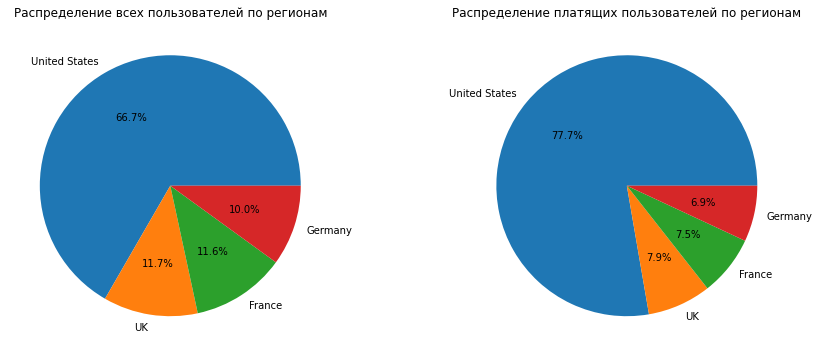

,user_id,payer,payment_rate
region,,,
United States,100002,6902,6.901862
UK,17575,700,3.982930
France,17450,663,3.799427
Germany,14981,616,4.111875


In [18]:
import matplotlib.pyplot as plt

# Группируем данные по регионам, подсчитываем общее количество пользователей и платящих пользователей
region_stats = profiles.groupby('region').agg({'user_id': 'count', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)

# Добавляем столбец с процентом платящих пользователей в каждом регионе
region_stats['payment_rate'] = (region_stats['payer'] / region_stats['user_id']) * 100

# Создаём круговые диаграммы для визуализации распределения пользователей
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Диаграмма доли всех пользователей по регионам
axes[0].pie(region_stats['user_id'], labels=region_stats.index, autopct='%1.1f%%')
axes[0].set_title('Распределение всех пользователей по регионам')

# Диаграмма доли платящих пользователей по регионам
axes[1].pie(region_stats['payer'], labels=region_stats.index, autopct='%1.1f%%')
axes[1].set_title('Распределение платящих пользователей по регионам')

# Отображаем диаграммы
plt.show()

# Выводим итоговую таблицу с рассчитанными данными
region_stats


**Выводы:**

**Распределение пользователей**  
- Большинство пользователей (**66.7%**) из **США**.  
- Великобритания, Франция и Германия составляют от **10% до 12%** каждый.  

**Распределение платящих пользователей**  
- **77.7%** платящих пользователей из **США**.  
- Остальные регионы (Германия, Франция, Великобритания) имеют примерно по **7–8% платящих**.  

**Процент платящих пользователей (Payment Rate)**  
- Наибольший процент платящих – **6.9%** в **США**.  
- **Германия** показывает **4.1%**, Великобритания – **4.0%**, Франция – **3.8%**.  

**Общие выводы**  
- **США** – ключевой рынок по числу пользователей и платящих.  
- Европейские регионы имеют схожую активность, но меньшую долю платящих.  


**Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи:**

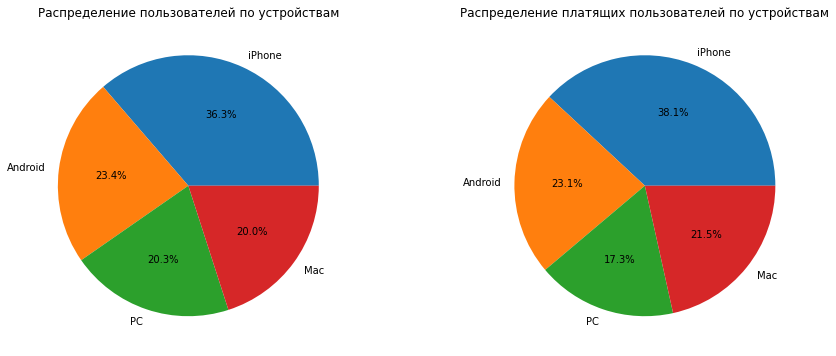

,user_id,payer,payment_rate
device,,,
iPhone,54479,3382,6.207897
Android,35032,2050,5.851793
PC,30455,1537,5.046790
Mac,30042,1912,6.364423


In [19]:
# Группируем данные по устройствам, подсчитываем общее число пользователей и платящих пользователей
device_stats = profiles.groupby('device').agg({'user_id': 'count', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)

# Добавляем столбец с процентом платящих пользователей для каждого типа устройства
device_stats['payment_rate'] = (device_stats['payer'] / device_stats['user_id']) * 100

# Создаём круговые диаграммы для визуализации распределения пользователей
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Диаграмма доли всех пользователей по устройствам
axes[0].pie(device_stats['user_id'], labels=device_stats.index, autopct='%1.1f%%')
axes[0].set_title('Распределение пользователей по устройствам')

# Диаграмма доли платящих пользователей по устройствам
axes[1].pie(device_stats['payer'], labels=device_stats.index, autopct='%1.1f%%')
axes[1].set_title('Распределение платящих пользователей по устройствам')

# Отображаем диаграммы
plt.show()

# Выводим итоговую таблицу с рассчитанными данными
device_stats


**Выводы:**

**Распределение пользователей**  
- Большинство пользователей используют **iPhone (36.3%)**.  
- Далее следуют **Android (23.4%)**, **PC (20.3%)** и **Mac (20.0%)**.  

**Распределение платящих пользователей**  
- Наибольшая доля платящих у **iPhone (38.1%)**.  
- Затем следуют **Android (23.1%)**, **Mac (21.5%)** и **PC (17.3%)**.  

**Процент платящих (Payment Rate)**  
- **Mac** лидирует с **6.36%**.  
- Далее следуют **iPhone (6.21%)**, **Android (5.85%)** и **PC (5.05%)**.  


**Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей:**

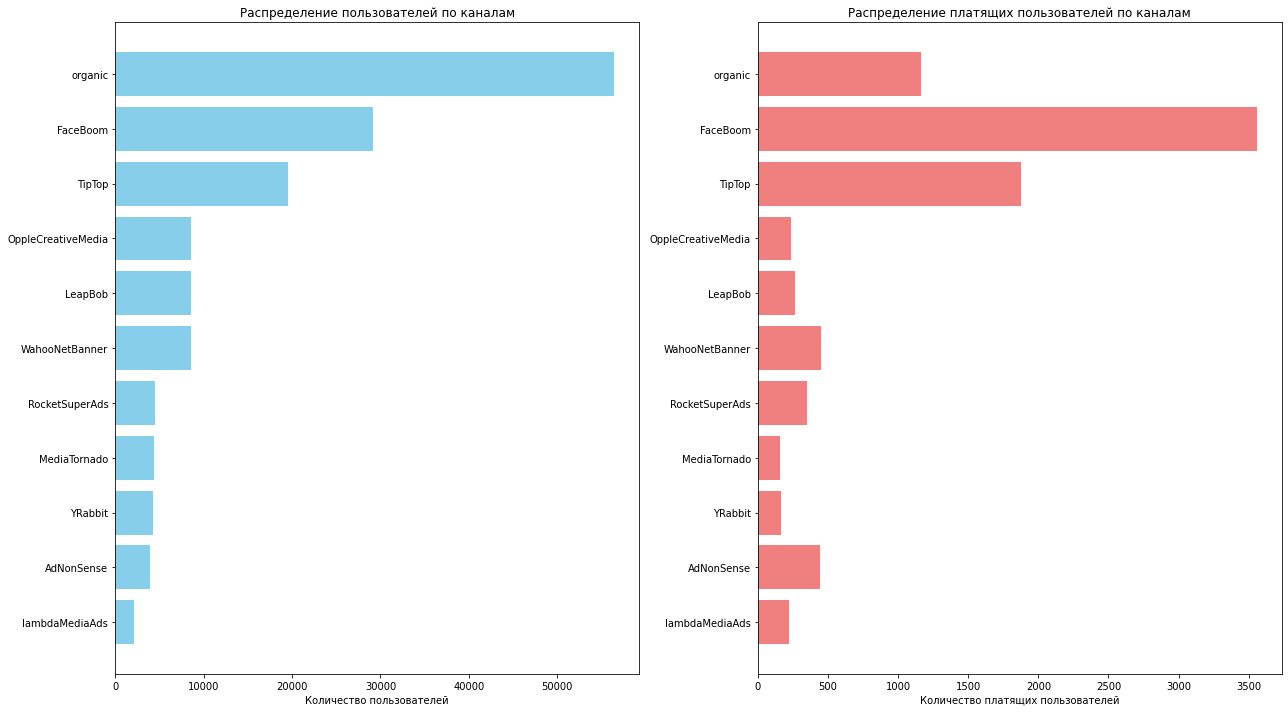

In [20]:
import matplotlib.pyplot as plt

# Группируем данные по каналам, подсчитываем общее количество пользователей и платящих пользователей
channel_stats = profiles.groupby('channel').agg({'user_id': 'count', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)

# Добавляем столбец с процентом платящих пользователей по каждому каналу
channel_stats['payment_rate'] = (channel_stats['payer'] / channel_stats['user_id']) * 100

# Сортируем данные по убыванию количества пользователей
channel_stats = channel_stats.sort_values(by='user_id', ascending=False)

# Создаём столбчатые диаграммы
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Диаграмма доли всех пользователей по каналам
axes[0].barh(channel_stats.index, channel_stats['user_id'], color='skyblue')
axes[0].set_title('Распределение пользователей по каналам')
axes[0].set_xlabel('Количество пользователей')
axes[0].invert_yaxis()

# Диаграмма доли платящих пользователей по каналам
axes[1].barh(channel_stats.index, channel_stats['payer'], color='lightcoral')
axes[1].set_title('Распределение платящих пользователей по каналам')
axes[1].set_xlabel('Количество платящих пользователей')
axes[1].invert_yaxis()

# Увеличиваем расстояние между графиками
plt.tight_layout()
plt.show()


**Выводы**:

**Распределение пользователей по каналам**  
- Канал **organic** привлекает большинство пользователей, значительно опережая остальные каналы.  
- На втором месте **FaceBoom**, затем **TipTop**.  
- Остальные каналы имеют заметно меньшую долю.  

**Распределение платящих пользователей**  
- Среди платящих пользователей лидирует **FaceBoom**, опережая **TipTop** и **organic**, несмотря на меньшее общее количество пользователей.  
- Остальные каналы также привлекают значительно меньше платящих.  


**Основные выводы по исследовательскому анализу данных:**

**Основные регионы**  
- **США** лидируют по числу пользователей и платящих.  
- Европейские регионы демонстрируют меньшую платёжную активность.  

**Устройства**  
- **iPhone** имеет наибольшее количество пользователей и платящих.  
- **Mac** показывает самый высокий процент платёжной активности.  

**Каналы привлечения**  
- **Organic** привлекает больше всего пользователей.  
- **FaceBoom** и **TipTop** обеспечивают больше платящих.  


### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.


**Посчитаем общую сумму расходов на маркетинг и выясним, как траты распределены по рекламным источникам**

In [21]:
total_costs = costs['costs'].sum()
print(f"Общая сумма затрат на рекламу составила {total_costs:,.2f}$")


Общая сумма затрат на рекламу составила 105,497.30$


Посмотрим на распределение маркетинговых расходов по источникам:

In [22]:
costs.groupby('channel').agg('sum').sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


**Вывод:**
основная часть маркетинговых расходов приходится на каналы TipTop и FaceBoom, которые суммарно составляют более 80% всех затрат.

Изучим динамику изменения расходов по времени (по неделям и месяцам) для каждого источника:

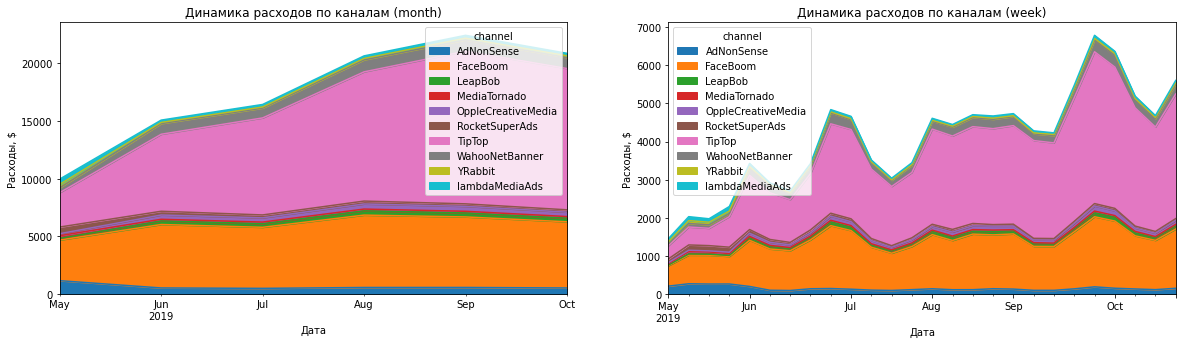

In [23]:
# Добавляем столбец с месяцами и неделями на основе даты
costs['month'] = costs['dt'].dt.to_period('M')
costs['week'] = costs['dt'].dt.to_period('W')

time_intervals = ['month', 'week']

# Построение графиков
plt.subplots(figsize=(20, 5))
for i, interval in enumerate(time_intervals):
    costs.pivot_table(index=interval, columns='channel', values='costs', aggfunc='sum').plot.area(ax=plt.subplot(1, 2, i + 1))
    plt.title(f'Динамика расходов по каналам ({interval})')
    plt.xlabel('Дата')
    plt.ylabel('Расходы, $')

plt.show()


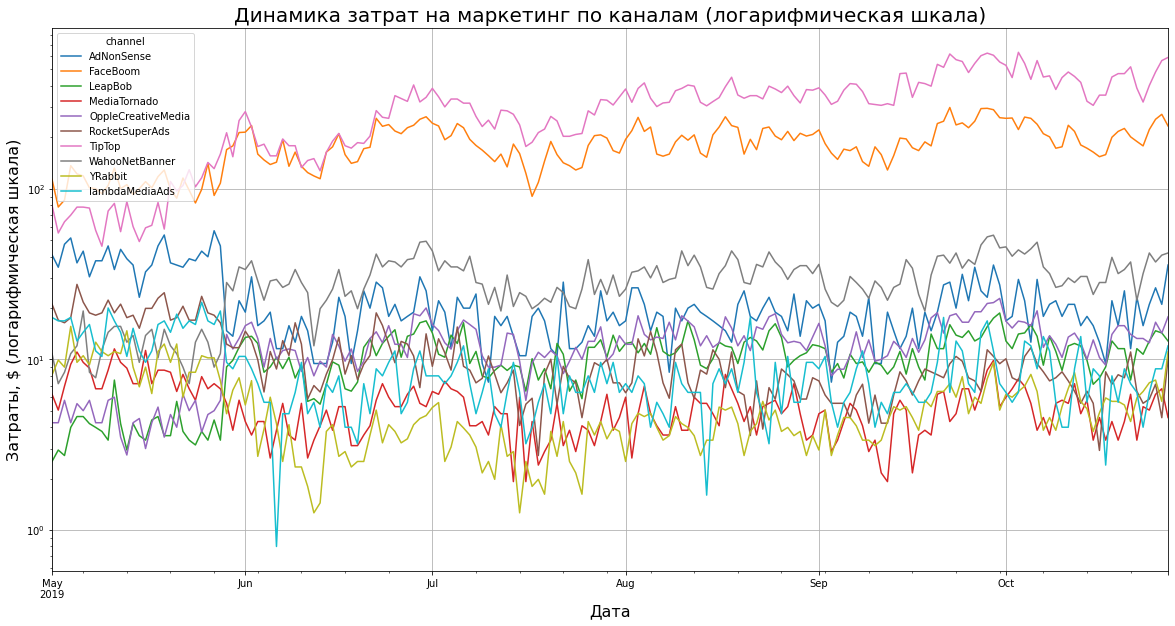

In [24]:
costs.pivot_table(
    index='dt', 
    columns='channel', 
    values='costs', 
).plot(figsize=(20, 10), grid=True, logy=True)  # Добавляем логарифмическую шкалу, чтобы были видны колебания менее затратных каналов 

plt.title('Динамика затрат на маркетинг по каналам (логарифмическая шкала)', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Затраты, $ (логарифмическая шкала)', fontsize=16)

plt.show()


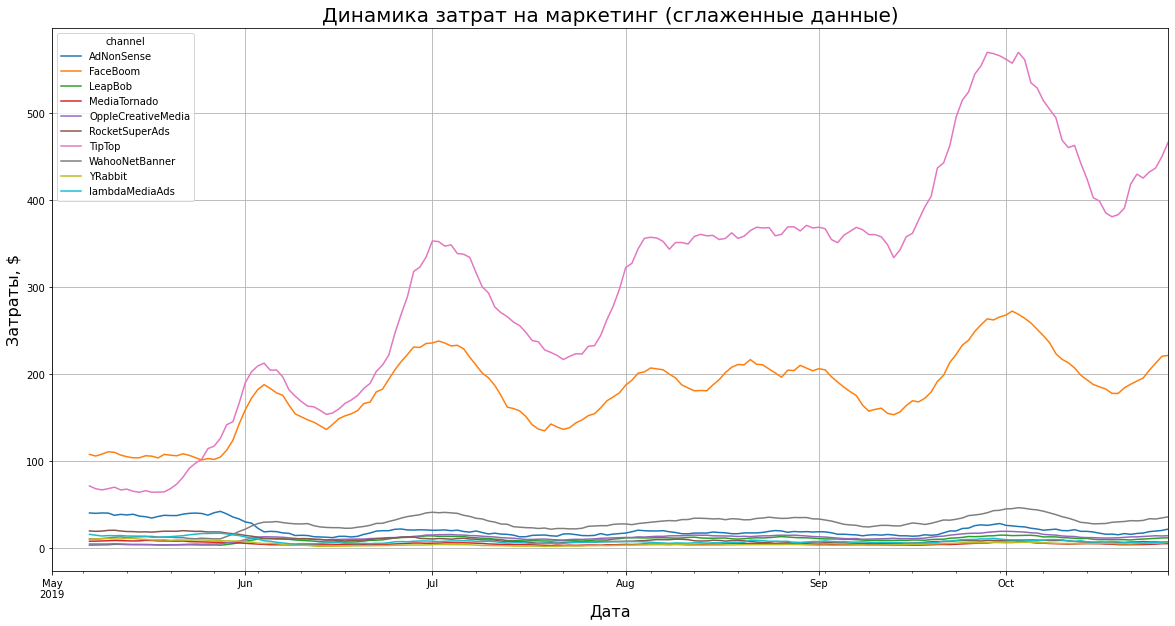

In [25]:
smoothed_costs = costs.pivot_table(
    index='dt', 
    columns='channel', 
    values='costs', 
    aggfunc='sum'
).rolling(window=7).mean()  # Скользящее среднее с окном 7 дней

smoothed_costs.plot(figsize=(20, 10), grid=True)

plt.title('Динамика затрат на маркетинг (сглаженные данные)', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Затраты, $', fontsize=16)
plt.show()


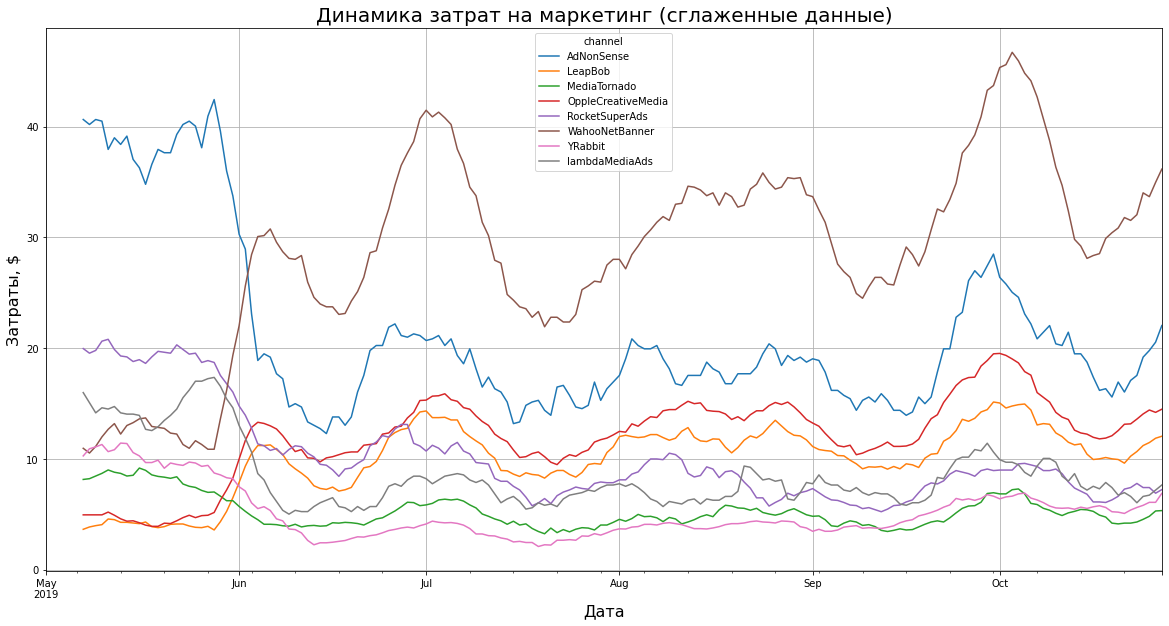

In [26]:
# Фильтрация данных для исключения каналов "TipTop" и "FaceBoom"
filtered_costs = costs.query('channel not in ["TipTop", "FaceBoom"]')

smoothed_costs = filtered_costs.pivot_table(
    index='dt',  
    columns='channel',  
    values='costs',  
    aggfunc='sum'  
).rolling(window=7).mean()  # Скользящее среднее с окном в 7 дней

smoothed_costs.plot(figsize=(20, 10), grid=True)

plt.title('Динамика затрат на маркетинг (сглаженные данные)', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Затраты, $', fontsize=16)
plt.show()


**Вывод:**

**Высокие затраты**  
- **TipTop** и **FaceBoom** доминируют с заметными пиками в **июле** и **октябре**.  

**Низкие затраты**  
- Каналы **YRabbit**, **MediaTornado** и другие остаются стабильными и малозначимыми.  

**Проанализируем динамику изменения CAC:**

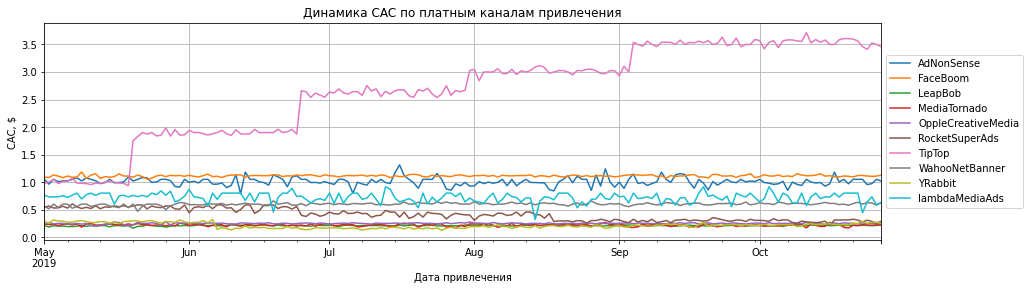

In [27]:
# Исключаем пользователей, привлечённых из бесплатных каналов
paid_profiles = profiles[profiles['acquisition_cost'] > 0]

# Анализ динамики изменения CAC по платным каналам
paid_cac_trend = paid_profiles.pivot_table(
    index='dt',
    columns='channel',
    values='acquisition_cost',
    aggfunc='mean'
)

paid_cac_trend.plot(grid=True, figsize=(15, 4))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика CAC по платным каналам привлечения')

plt.show()


**Выводы:**

**Высокий CAC**  
- Канал **TipTop** показывает самый высокий CAC, превышающий **$3**, с устойчивым ростом.  

**Стабильный CAC**  
- Большинство каналов, включая **FaceBoom** и **AdNonSense**, имеют стабильный CAC ниже **$1**.  


### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построем и графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализирем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

**Проанализируем окупаемость рекламы c помощью графиков LTV, ROI и CAC, а также графики динамики LTV, CAC и ROI:**

In [28]:
profiles = profiles.query('channel != "organic"') #исключим из таблицы органических пользователей.
observation_date = profiles['dt'].max() #момент анализа
horizon_days = 14 #горизонт анализа - 2 недели

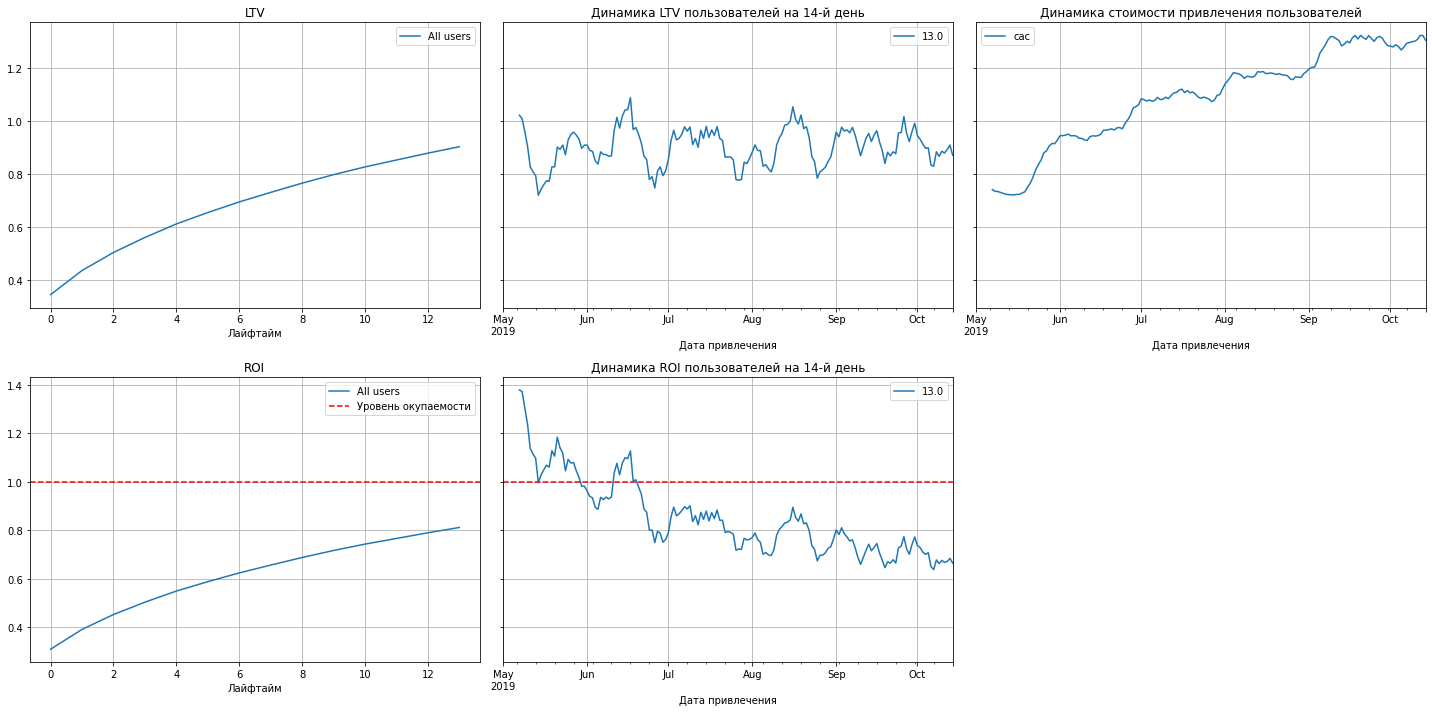

In [29]:
# Вызовем функцию для расчета LTV, ROI и их динамики
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# Построим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Вывод:**

**LTV**  
- Пользовательская ценность стабильно растёт на всём лайфтайме, что говорит о хорошем состоянии продукта.  

**LTV на 14-й день**  
- Показатели стабильны и практически не меняются, что свидетельствует об отсутствии проблем с поведением пользователей и интересом к продукту.  

**CAC**  
- Стоимость привлечения клиента растёт, что означает снижение эффективности маркетинга.  

**ROI**  
- На 14-й день окупаемость не достигается, доходы покрывают лишь **80% затрат**.  
- Приложение окупалось только в мае.  

**Проверим конверсию пользователей и динамику её изменения, а так же удержание пользователей. Построим и изучим графики конверсии и удержания:**

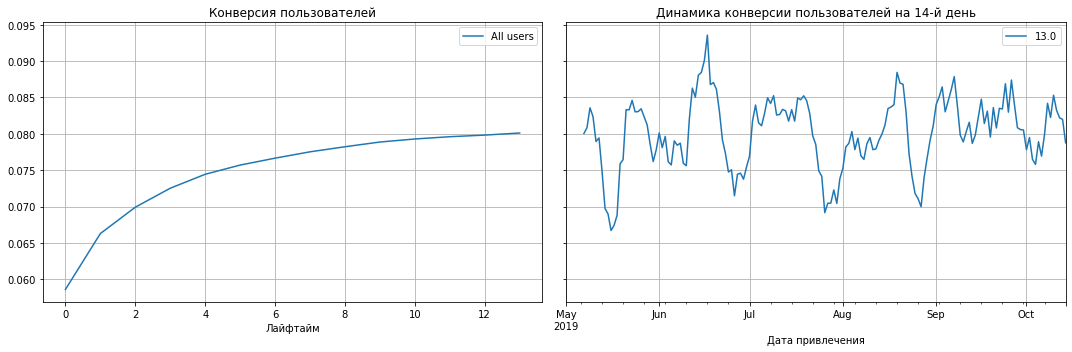

In [30]:
# Вызовем функцию для расчёта конверсии
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

**Вывод**:
Конверсия демонстрирует стабильный рост и отсутствие значительных проблем в привлечении и удержании пользователей.

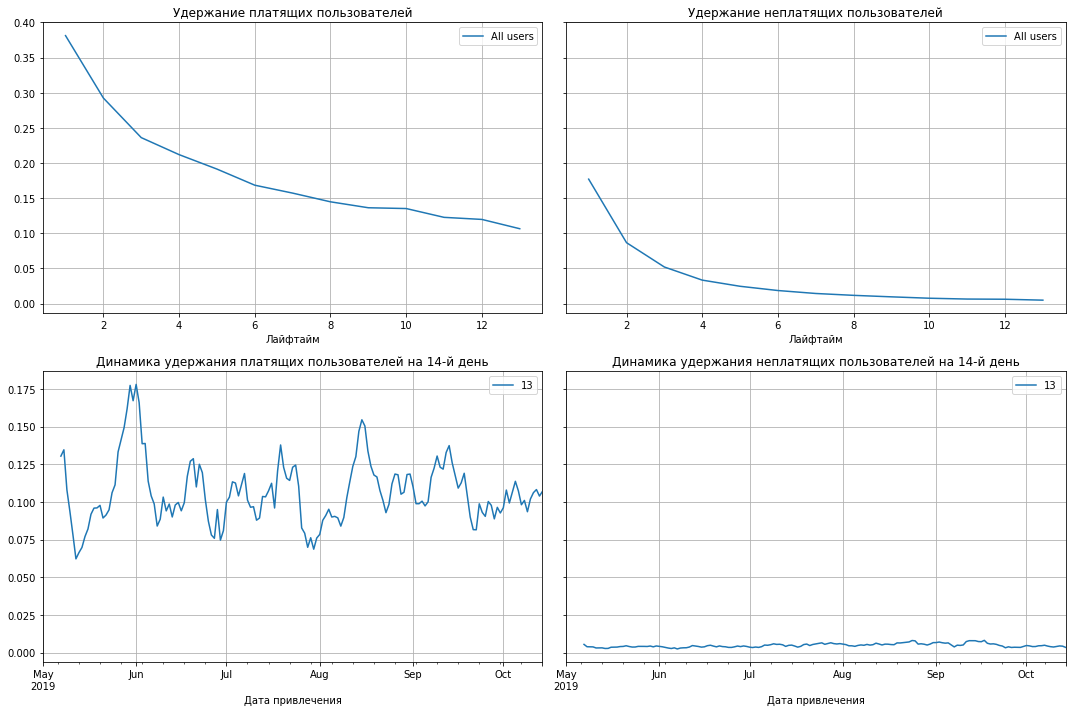

In [31]:
#Вызов функции для расчёта удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

**Выводы:**

**Удержание платящих пользователей**  
- Удержание падает со временем, но остаётся выше, чем у неплатящих пользователей.  

**Удержание неплатящих пользователей**  
- Значительно ниже и быстро стремится к нулю, что указывает на слабую вовлечённость.  

**Динамика на 14-й день**  
- Удержание платящих пользователей показывает колебания, но остаётся стабильным.  
- Удержание неплатящих практически неизменно низкое.  


**Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI**

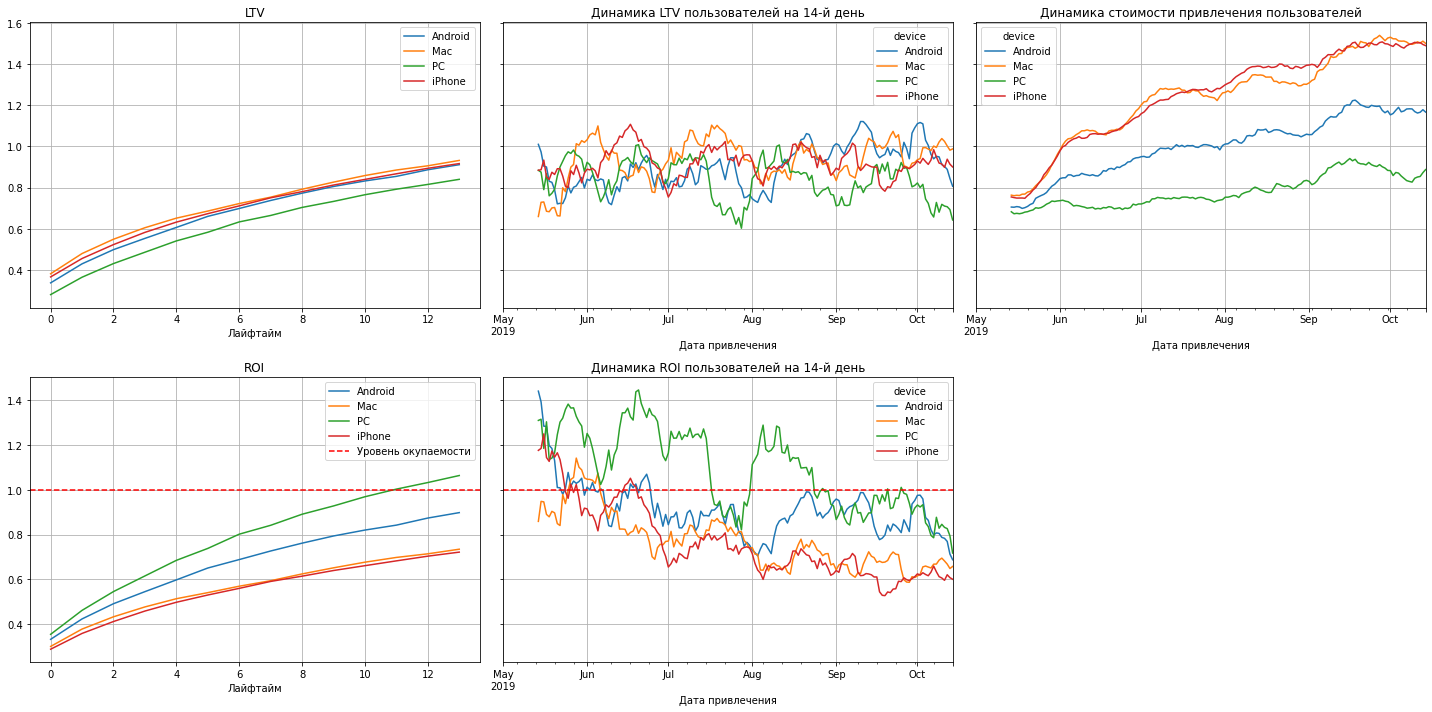

In [32]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы**:

**LTV**  
- Пользователи **iPhone** и **Mac** имеют самый высокий LTV, особенно на длительном лайфтайме.  
- **PC** демонстрирует самый низкий показатель.  

**CAC**  
- Стоимость привлечения пользователей **iPhone** значительно выше по сравнению с другими устройствами, что снижает общую эффективность.  

**ROI**  
- Пользователи **Mac** быстрее окупаются, достигая уровня **ROI > 1**.  
- **PC** и **Android** остаются ниже уровня окупаемости.  
- **iPhone** демонстрирует стабильный, но низкий ROI из-за высокого CAC.  


**Рассчитаем конверсию пользователей с разбивкой по устройствам:**

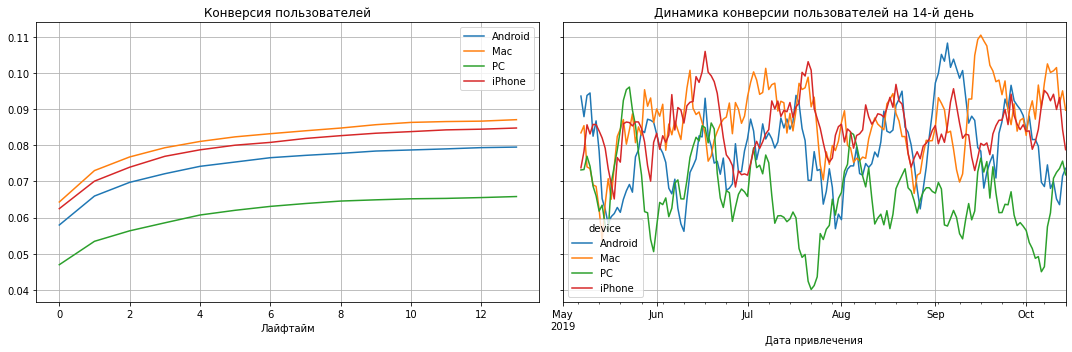

In [33]:
group_by = ['device']

conversion_raw, conversion_by_device, conversion_trend = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=group_by
)

plot_conversion(conversion_by_device, conversion_trend, horizon_days)


**Выводы:**

**Конверсия пользователей (лайфтайм)**  
- Самая высокая конверсия у пользователей **iPhone** и **Mac**, достигает **9%**.  
- Пользователи **PC** имеют самый низкий уровень конверсии (~**6%**), что указывает на их меньшую вовлечённость.  

**Динамика конверсии на 14-й день**  
- Конверсия на 14-й день у пользователей **iPhone** и **Mac** остаётся стабильной с некоторыми колебаниями.  
- Конверсия пользователей **PC** показывает нестабильность и остаётся самой низкой.  


**Пронализируем удержание пользователей с разбивкой по устройствам:**


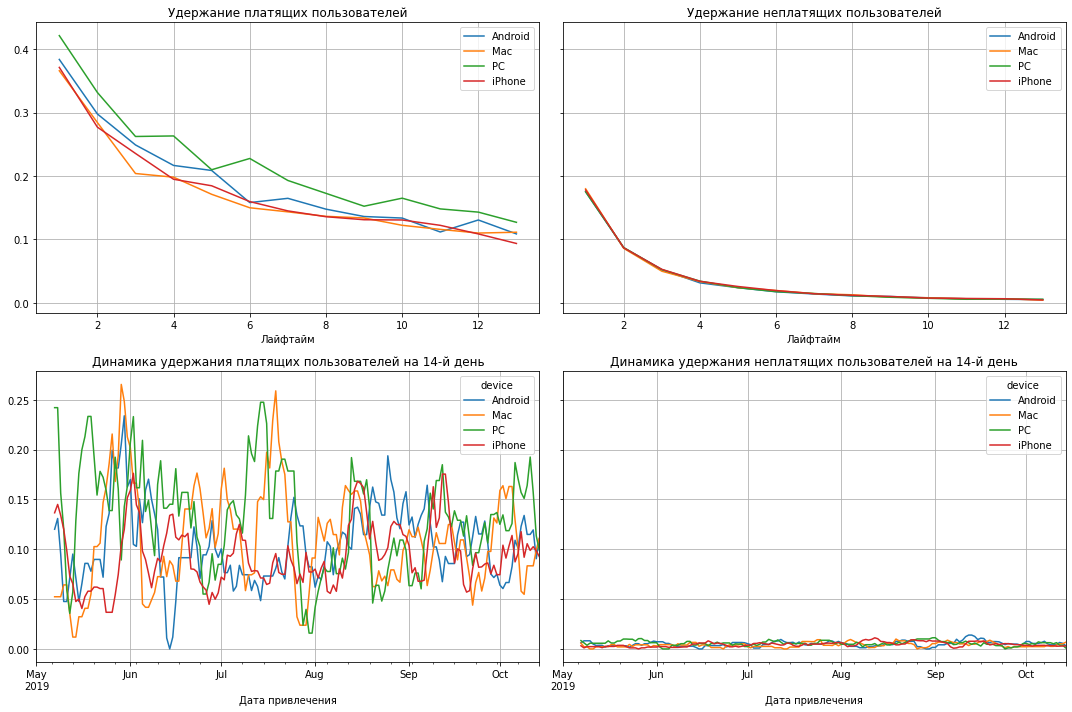

In [34]:
group_by = ['device']

retention_raw, retention_by_device, retention_trend = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=group_by
)

plot_retention(retention_by_device, retention_trend, horizon_days)


**Вывод:** удержание платящих пользователей похоже для всех устройств, неплатящие пользователи всех устройств практически не удерживаются.

**Проанализируем окупаемость рекламы по странам:**

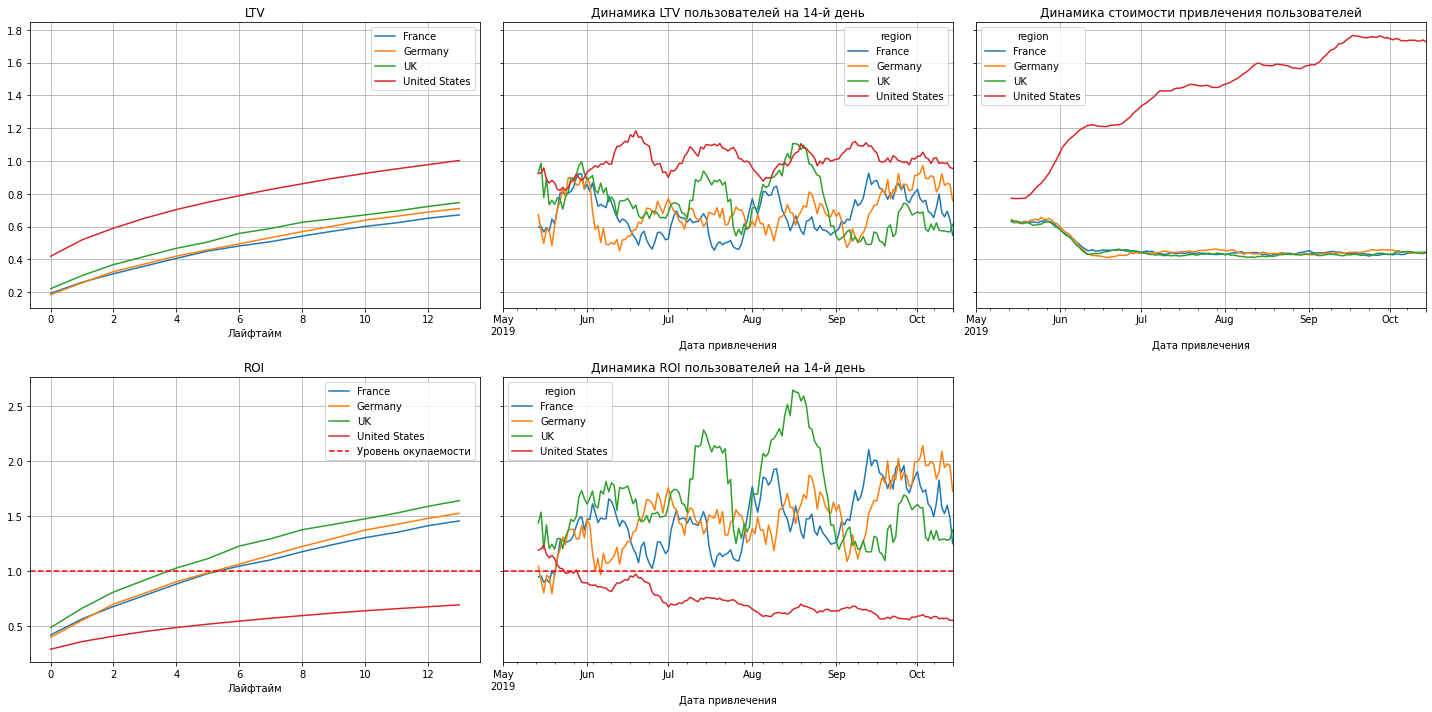

In [35]:
group_by = ['region']

ltv_data, ltv_by_region, ltv_trend, roi_by_region, roi_trend = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=group_by
)

plot_ltv_roi(
    ltv_by_region,
    ltv_trend,
    roi_by_region,
    roi_trend,
    horizon_days,
    window=14
)


**LTV**  
- Самый высокий в **США**, **Франция**, **Германия** и **Великобритания** находятся на одном уровне.  

**CAC**  
- Значительно выше в **США**, в других регионах остаётся стабильным и низким.  

**ROI**  
- Наибольший в **Германии** (**ROI > 1**).  
- **Франция** и **Великобритания** достигают окупаемости.  
- **США** остаются убыточными (**ROI < 1**).  

**Динамика на 14-й день**  
- В **США** заметны сильные колебания.  
- В остальных регионах показатели стабильны.  

Таким образом, причина убыточности приложения связана с поведением пользователей из США. Хотя они имеют высокий LTV, их ROI остаётся ниже, чем в других странах, и фактически не достигает окупаемости. Это связано с высоким САС, который продолжает стремительно расти. Падение ROI совпадает с резким ростом затрат на рекламу. 

**Пронализируем конверсию с разбивкой по регионам:**

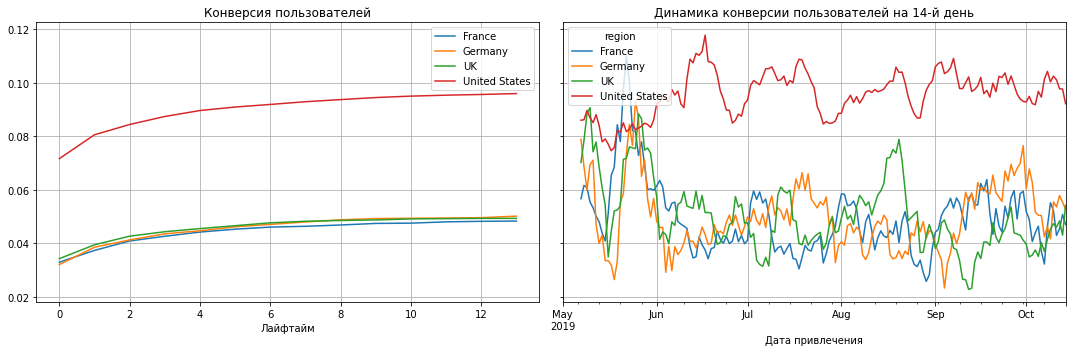

In [36]:
group_by = ['region']

conversion_data, conversion_by_region, conversion_trend = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=group_by
)

plot_conversion(conversion_by_region, conversion_trend, horizon_days)


**Вывод:**

**Конверсия пользователей**  
- Пользователи из **США** имеют самую высокую конверсию (до **10%**) на протяжении лайфтайма, значительно опережая другие регионы.  

**Динамика конверсии на 14-й день**  
- Конверсия пользователей из **США** остаётся стабильно высокой.  
- В других странах она ниже и менее стабильна.  


**Рассчитаем удержание пользователей с разбивкой по регионам:**

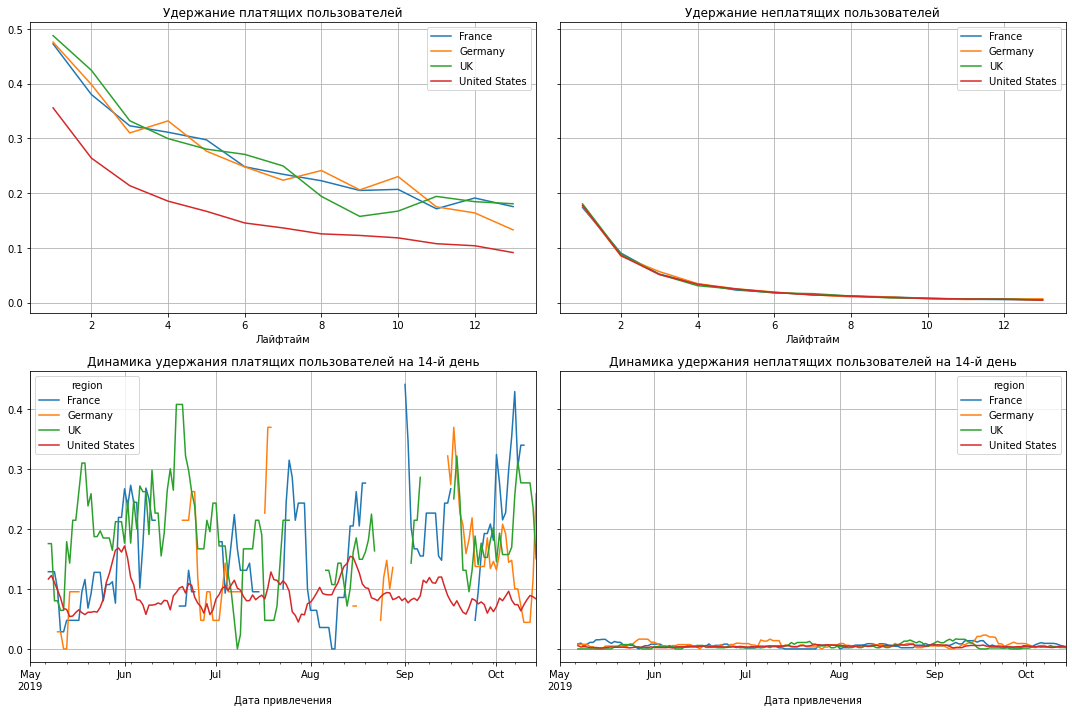

In [37]:
retention_data, retention_by_region, retention_trend = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_by_region, retention_trend, horizon_days)

**Выводы:**

**Удержание платящих пользователей**  
- Пользователи из **США** имеют самое низкое удержание на всём лайфтайме.  

**Удержание неплатящих пользователей**  
- Независимо от региона, удержание неплатящих пользователей быстро снижается до нуля и практически не отличается между странами.  

**Динамика на 14-й день**  
- В **США** наблюдается значительно более низкий уровень удержания.  
- Удержание неплатящих остаётся минимальным.  


**Проанализируем окупаемость рекламы в зависимости от канала привлечения:**

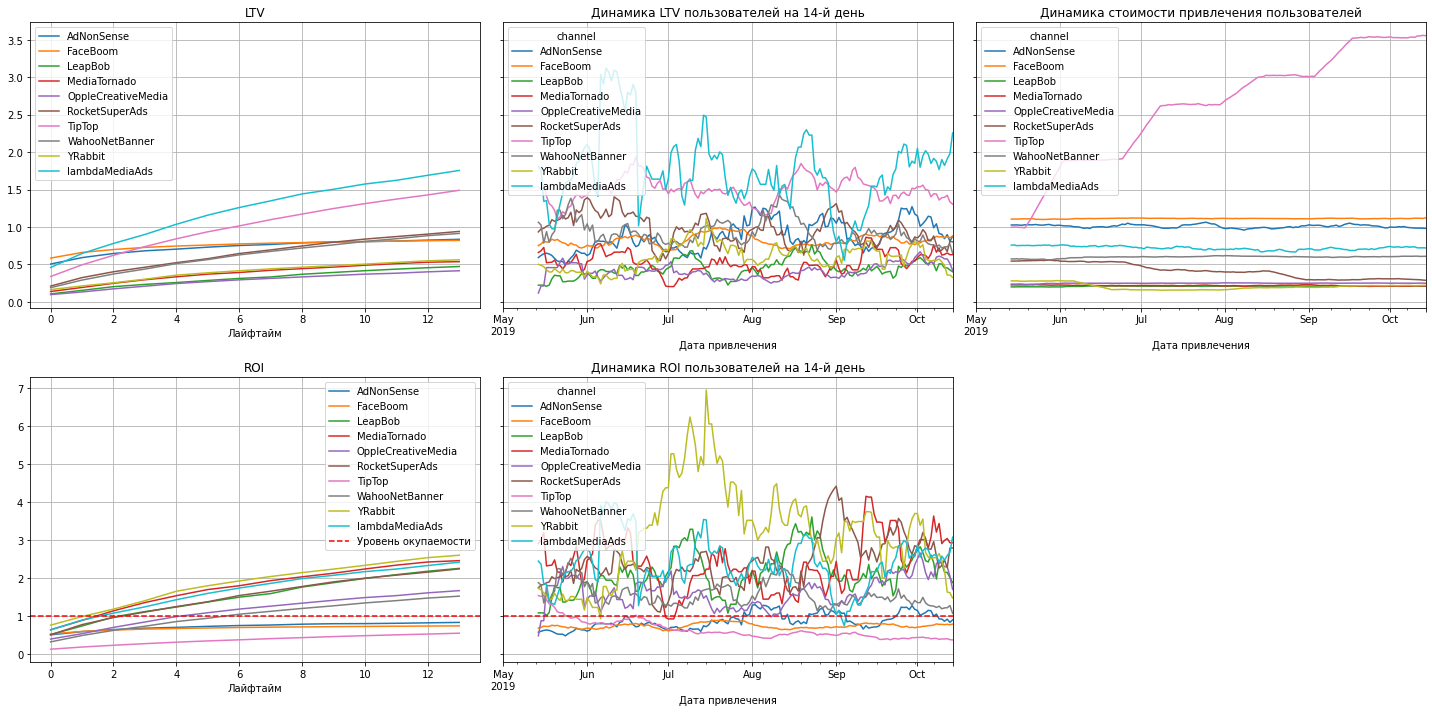

In [38]:
group_by = ['channel']

ltv_data, ltv_by_channel, ltv_trend, roi_by_channel, roi_trend = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=group_by
)

plot_ltv_roi(
    ltv_by_channel,
    ltv_trend,
    roi_by_channel,
    roi_trend,
    horizon_days,
    window = 14
)

**Вывод**  
- Каналы **FaceBoom** и **TipTop** требуют оптимизации из-за высоких затрат и низкой окупаемости.  
- **LambdaMedaAds**, **Yrabbit** и **MediaTornado** показывают наилучшие результаты.  


**Проанализируем конверсию с разбивкой по каналам привлечения:**

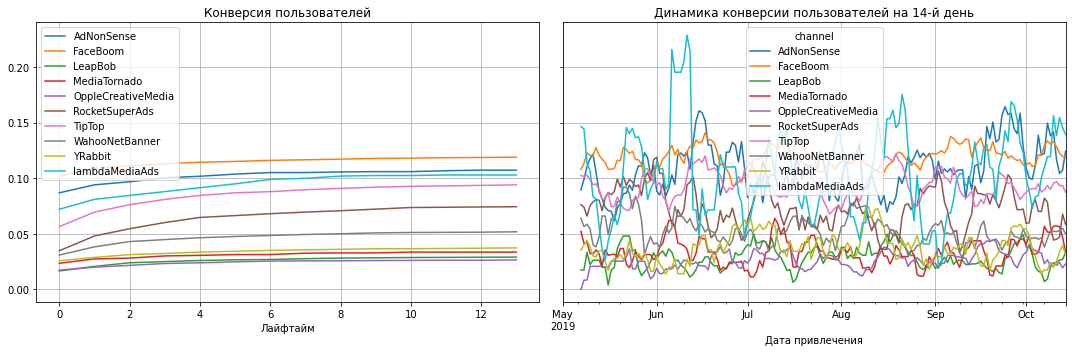

In [39]:
group_by = ['channel']

conversion_data, conversion_by_channel, conversion_trend = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=group_by
)

plot_conversion(conversion_by_channel, conversion_trend, horizon_days)

**Выводы:**

**Низкая конверсия**  
- **OppleCreativeMedia**, **MediaTornado**, **YRabbit**, и **LeapBob** показывают слабую эффективность.  

**Нестабильная динамика**  
- **LambdaMediaAds** характеризуется резкими скачками и падениями, что снижает надёжность.  

**Стабильные каналы**  
- **AdNonSense** и **FaceBoom** демонстрируют устойчивую конверсию и вовлечённость.  


**Проанализируем удержание пользователей с разбивкой по каналам привлечения:**


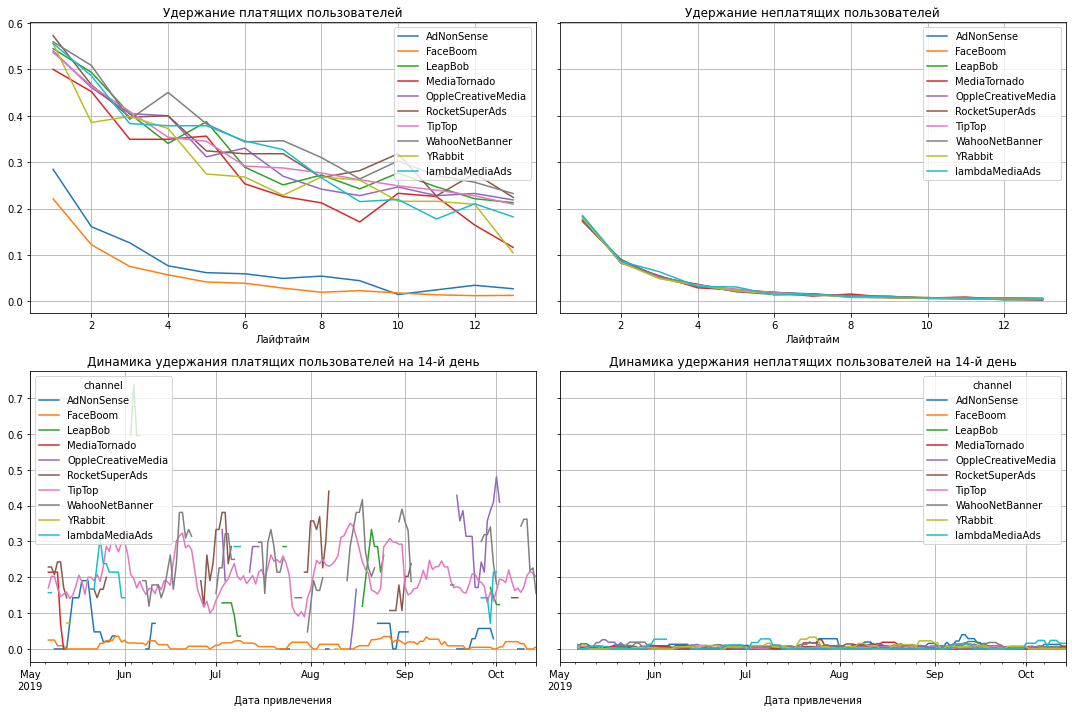

In [40]:
retention_data, retention_by_channel, retention_trend = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_by_channel, retention_trend, horizon_days)

**Выводы:**

**Удержание платящих пользователей**  
- **AdNonSense** и **FaceBoom** демонстрируют самые низкие показатели удержания на всём лайфтайме, что делает их неэффективными каналами.  
- Остальные каналы показывают более стабильные результаты.

**Удержание неплатящих пользователей**  
- Практически идентичное снижение для всех каналов, с быстрым достижением нулевого уровня. 

### Основные выводы  

#### Рынки и регионы  
- **США** – крупнейший рынок по числу пользователей и платящих, однако высокий **CAC** делает этот регион убыточным.  
- Европейские страны (**Германия**, **Франция**, **Великобритания**) показывают стабильные **ROI** и более низкие затраты, что делает их перспективными для увеличения маркетинговых инвестиций.  

#### Устройства  
- **Mac** и **iPhone** демонстрируют самые высокие **LTV** и конверсии.  
  - Однако **iPhone** остаётся убыточным из-за высокого **CAC**.  
- Владельцы **ПК** показывают лучшую окупаемость, что делает их приоритетной аудиторией для удержания.  

#### Каналы привлечения  
- **FaceBoom** и **TipTop**:  
  - Доминируют в затратах, но показывают низкий **ROI** из-за высокого **CAC** и плохого удержания.  
- **LambdaMediaAds**, **YRabbit**, и **MediaTornado**:  
  - Демонстрируют хорошие показатели конверсии и **ROI**, хотя требуют дополнительного анализа.  

#### Удержание  
- Удержание платящих пользователей:  
  - В **США** значительно ниже, чем в других регионах.  
- Удержание пользователей по каналам:  
  - **FaceBoom** и **AdNonSense** имеют худшее удержание, что делает их экономически неэффективными.  

#### Динамика конверсии и ROI  
- **США**:  
  - Конверсия остаётся высокой, но **ROI** не достигает уровня окупаемости из-за растущих затрат.  
- Органический трафик:  
  - Снижается с **мая 2019 года**, что негативно влияет на конверсию в Европе.  

---

### Рекомендации для отдела маркетинга  

#### Оптимизация затрат в США  
- Сократить расходы на маркетинг в **США**, особенно в каналах **FaceBoom** и **TipTop**, которые не окупаются.  
- Перераспределить бюджеты на европейский рынок, где **CAC** ниже, а эффективность выше.  

#### Увеличение доли европейского рынка  
- Увеличить маркетинговые усилия в **Германии**, **Франции** и **Великобритании**, где **ROI** стабильно превышает 1.  
- Сфокусироваться на пользователях **ПК** и **Android**, которые демонстрируют высокий потенциал роста.  

#### Пересмотр стратегии по каналам  
- Провести анализ эффективности каналов **FaceBoom** и **TipTop**.  
- Перераспределить бюджеты на более эффективные каналы, такие как **LambdaMediaAds**, **YRabbit**, и **MediaTornado**.  
- Сократить расходы на слабые каналы, такие как **AdNonSense** и **OppleCreativeMedia**.  

#### Работа с продуктом  
- Оптимизировать **UX** для повышения удержания пользователей на всех устройствах, особенно для **Android** и **ПК**.  
- Исследовать причины снижения органического трафика с **мая 2019 года** и предпринять меры для его восстановления.  

#### Дополнительные меры  
- Анализировать поведение пользователей из **США**, чтобы выявить причины низкого удержания и окупаемости.  
- Повышать качество рекламы через более точный таргетинг и улучшенные креативы.  
